# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch

# Kullanılmayan bellekleri temizle
torch.cuda.empty_cache()

# Zorla kullanılmayan memory'yi bırak
torch.cuda.ipc_collect()

print("GPU belleği temizlendi.")


GPU belleği temizlendi.


### Preprocessing and Image Display

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torchvision.transforms.functional as TF
import numpy as np


In [4]:
class ESPCN(nn.Module):
    def __init__(self, scale_factor=3):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x


In [5]:
class HistopathologySRDataset(Dataset):
    def __init__(self, image_dir, transform_hr, transform_lr):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')
        hr = self.transform_hr(img)
        lr = self.transform_lr(img)
        return lr, hr

# 255x255 çözünürlük, modelin çıktısına eşit (scale factor 3 x 85 = 255)
transform_hr = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])


# 85x85 düşük çözünürlük (scale=3), model kendi upsample eder
transform_lr = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [6]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for lr, hr in tqdm(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            loss = criterion(sr, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")


In [7]:
def evaluate_sr_quality(model, dataset, device, index=0):
    model.eval()
    with torch.no_grad():
        lr, hr = dataset[index]
        lr = lr.unsqueeze(0).to(device)
        hr = hr.unsqueeze(0).to(device)

        sr = model(lr).clamp(0.0, 1.0)

        sr_np = sr.squeeze().cpu().permute(1, 2, 0).numpy()
        hr_np = hr.squeeze().cpu().permute(1, 2, 0).numpy()

        psnr = peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)
        ssim = structural_similarity(hr_np, sr_np, data_range=1.0, channel_axis=2)

        print(f"🔍 PSNR: {psnr:.2f} dB")
        print(f"🔍 SSIM: {ssim:.4f}")

        lr_img = TF.to_pil_image(lr.squeeze(0).cpu())
        hr_img = TF.to_pil_image(hr.squeeze(0).cpu())
        sr_img = TF.to_pil_image(sr.squeeze(0).cpu())
        print("Görüntü boyutu:", sr_img.size)  # (yükseklik, genişlik, kanal sayısı)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Low-Res (Input)")
        plt.imshow(lr_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(f"Super-Res\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
        plt.imshow(sr_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("High-Res (GT)")
        plt.imshow(hr_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = HistopathologySRDataset(image_dir="downsampled_images", transform_hr=transform_hr, transform_lr=transform_lr)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = ESPCN(scale_factor=2).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, criterion, optimizer, num_epochs=50, device=device)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.66it/s]


Epoch 1/50, Loss: 0.1026


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.31it/s]


Epoch 2/50, Loss: 0.0176


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 13.99it/s]


Epoch 3/50, Loss: 0.0121


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.71it/s]


Epoch 4/50, Loss: 0.0099


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 12.92it/s]


Epoch 5/50, Loss: 0.0085


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.72it/s]


Epoch 6/50, Loss: 0.0077


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 11.99it/s]


Epoch 7/50, Loss: 0.0070


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.87it/s]


Epoch 8/50, Loss: 0.0066


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.76it/s]


Epoch 9/50, Loss: 0.0064


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.43it/s]


Epoch 10/50, Loss: 0.0058


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.57it/s]


Epoch 11/50, Loss: 0.0056


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.25it/s]


Epoch 12/50, Loss: 0.0053


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.08it/s]


Epoch 13/50, Loss: 0.0050


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.05it/s]


Epoch 14/50, Loss: 0.0050


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.08it/s]


Epoch 15/50, Loss: 0.0047


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.20it/s]


Epoch 16/50, Loss: 0.0044


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.06it/s]


Epoch 17/50, Loss: 0.0043


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.87it/s]


Epoch 18/50, Loss: 0.0042


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.08it/s]


Epoch 19/50, Loss: 0.0044


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.53it/s]


Epoch 20/50, Loss: 0.0039


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.62it/s]


Epoch 21/50, Loss: 0.0039


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.82it/s]


Epoch 22/50, Loss: 0.0037


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.87it/s]


Epoch 23/50, Loss: 0.0040


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.67it/s]


Epoch 24/50, Loss: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.85it/s]


Epoch 25/50, Loss: 0.0034


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.02it/s]


Epoch 26/50, Loss: 0.0041


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.35it/s]


Epoch 27/50, Loss: 0.0033


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.06it/s]


Epoch 28/50, Loss: 0.0032


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.59it/s]


Epoch 29/50, Loss: 0.0032


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:15<00:00, 10.89it/s]


Epoch 30/50, Loss: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:15<00:00, 10.94it/s]


Epoch 31/50, Loss: 0.0031


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:14<00:00, 11.22it/s]


Epoch 32/50, Loss: 0.0033


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.44it/s]


Epoch 33/50, Loss: 0.0030


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.66it/s]


Epoch 34/50, Loss: 0.0029


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.66it/s]


Epoch 35/50, Loss: 0.0033


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.77it/s]


Epoch 36/50, Loss: 0.0031


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.56it/s]


Epoch 37/50, Loss: 0.0028


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.85it/s]


Epoch 38/50, Loss: 0.0032


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.42it/s]


Epoch 39/50, Loss: 0.0027


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.34it/s]


Epoch 40/50, Loss: 0.0028


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 13.92it/s]


Epoch 41/50, Loss: 0.0027


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.50it/s]


Epoch 42/50, Loss: 0.0027


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.80it/s]


Epoch 43/50, Loss: 0.0026


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.88it/s]


Epoch 44/50, Loss: 0.0028


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 13.98it/s]


Epoch 45/50, Loss: 0.0026


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.74it/s]


Epoch 46/50, Loss: 0.0031


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.40it/s]


Epoch 47/50, Loss: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.81it/s]


Epoch 48/50, Loss: 0.0024


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.00it/s]


Epoch 49/50, Loss: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.53it/s]

Epoch 50/50, Loss: 0.0025


🔍 PSNR: 47.18 dB
🔍 SSIM: 0.9902
Görüntü boyutu: (512, 512)


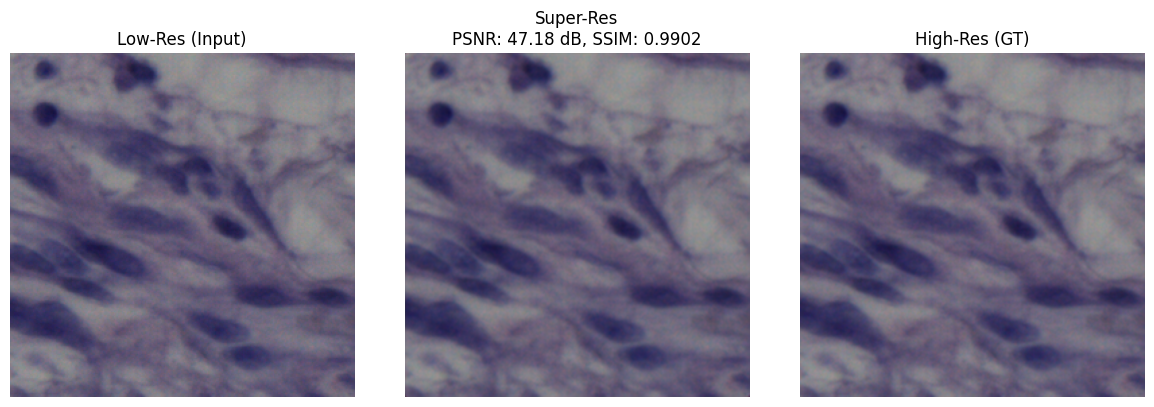

In [9]:
evaluate_sr_quality(model, dataset, device, index=0)


In [10]:
torch.save(model, "espcn_x2_256to512.pth")